In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

In [2]:
train = pd.read_csv('test.csv')


# Age + Date_of_birth
Date_of_birth obsahuje formáty:<br>
YYYY-MM-DD 00 00 00<br>
DD-MM-YYYY  0:00:00<br>
DD-MM-YYYY (Obsahuje chyby - dôkazom toho je hneď prvý záznam s 02-10-2029, dalo by sa to opraviť na 1929 a tak by to korešpondovalo s rokmi, no pandas nevie prečítať posledné 2 čísla YY)<br>
Z nasledujúceho výstupu je možné odhadnúť treshold na základe ktorého by sa dalo nájsť storočie pre každý rok (ak ich všetky majú na rovnako). Snahou bolo to transformovať do presných rokov, no po dlhom trápení sa to radšej zjednodušilo do tvaru DD-MM-YY.

Age obsahuje jeden záznam s rokmi 455, aj keď korešponduje s dátumom narodenia, zahodíme ho lebo aj tak ním nestratíme veľa info pri klasifikácii.

In [3]:
train['date_of_birth'] = train['date_of_birth'].str.extract('(\d*-\d\d-\d\d)', expand=True)
train.drop(train[train['age'] > 120].index, inplace=True)
train['date_of_birth'] = pd.to_datetime(train['date_of_birth'], errors='coerce')
train['date_of_birth'] = train['date_of_birth'].dt.strftime('%d-%m-%y')
train[(train['age'] < 20)][112:116][['age', 'date_of_birth']]


Empty DataFrame
Columns: [age, date_of_birth]
Index: []

In [4]:
train['sex'].value_counts()

F    650
M    282
?     40
Name: sex, dtype: int64

In [5]:
train['personal_info'].head()

0    Black|United-States\nHS-grad -- Never-married|...
1    White|India\nAssoc-acdm -- Never-married|Own-c...
2    Black|United-States\n11th -- Never-married|Not...
3    White|United-States\nMasters -- Never-married|...
4    White|United-States\nSome-college -- Married-c...
Name: personal_info, dtype: object

# There are important and related information to almost all of the colums in personal- info Column



We can devide personal_info atribute into 5 individual atributes


In [6]:
pom = None
pom = train['personal_info'].str.split('[|]', 1, expand=True) 
              # rename(columns={0:'class', 1:'class number'})
#train.merge(pom, on='class', how='right')      # why isnt this working???!!!!
train.drop(columns=['personal_info'], inplace=True)
train['race'] = pom[0]
train['personal_info'] = pom[1]
train['personal_info'] = train['personal_info'].astype(str) 






In [7]:
train['personal_info'].head()

0    United-States\nHS-grad -- Never-married|Not-in...
1         India\nAssoc-acdm -- Never-married|Own-child
2    United-States\n11th -- Never-married|Not-in-fa...
3    United-States\nMasters -- Never-married|Not-in...
4    United-States\nSome-college -- Married-civ-spo...
Name: personal_info, dtype: object

In [8]:
pom = train['personal_info'].str.split('\n', 1, expand=True)   # rename(columns={0:'class', 1:'class number'})

#train.merge(pom, on='class', how='right')      # why isnt this working???!!!!
train.drop(columns=['personal_info'], inplace=True)
train['Country'] = pom[0]
train['personal_info2'] = pom[1]     
train['personal_info2'] = train['personal_info2'].astype(str) 


In [9]:
train['personal_info2'].head()

0        HS-grad -- Never-married|Not-in-family
1         Assoc-acdm -- Never-married|Own-child
2           11th -- Never-married|Not-in-family
3        Masters -- Never-married|Not-in-family
4    Some-college -- Married-civ-spouse|Husband
Name: personal_info2, dtype: object

In [10]:
pom = train['personal_info2'].str.split('--', 1, expand=True)   # rename(columns={0:'class', 1:'class number'})

#train.merge(pom, on='class', how='right')      # why isnt this working???!!!!
train.drop(columns=['personal_info2'], inplace=True)
train['education-status'] = pom[0]
train['personal_info3'] = pom[1]
train['personal_info3'] = train['personal_info3'].astype(str) 




In [11]:
train['personal_info3'].head()

0     Never-married|Not-in-family
1         Never-married|Own-child
2     Never-married|Not-in-family
3     Never-married|Not-in-family
4      Married-civ-spouse|Husband
Name: personal_info3, dtype: object

In [12]:
pom = train['personal_info3'].str.split('[|]', 1, expand=True)   # rename(columns={0:'class', 1:'class number'})

#train.merge(pom, on='class', how='right')      # why isnt this working???!!!!
train.drop(columns=['personal_info3'], inplace=True)

train['marital-status'] = pom[0]
train['personal_info'] = pom[1]
train['personal_info'] = train['personal_info'].astype(str) 


In [13]:
train['personal_info'].head()

0    Not-in-family
1        Own-child
2    Not-in-family
3    Not-in-family
4          Husband
Name: personal_info, dtype: object

In [14]:
train['class'].head()


0    negative._2746
1    negative.|1391
2    negative.|2764
3    negative.|2157
4     negative.|433
Name: class, dtype: object

# class + class number
rozdelenie atribútu class na 2

In [15]:
pom = train['class'].str.split('.[|_]', 1, expand=True)   # rename(columns={0:'class', 1:'class number'})
#train.merge(pom, on='class', how='right')      # why isnt this working???!!!!
train.drop(columns=['class'], inplace=True)
train['class'] = pom[0]
train['class number'] = pom[1]
train['class number'] = train['class number'].astype(int) 
train['class number'].describe()




count     972.000000
mean     1860.276749
std      1083.076925
min        21.000000
25%       901.500000
50%      1812.500000
75%      2802.000000
max      3770.000000
Name: class number, dtype: float64

In [16]:
#train.to_csv('repaired.csv')

Now we have devided the personal_info atribute into 5 atributes and class in to class and class number so that we can use furhter for preprocessing and cleaning data


In [17]:
class Abc(TransformerMixin):
    def __init__(self, column, source, target):
        self.column = column
        self.source = source
        self.target = target
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        sample = df[self.column] == self.source
        df.loc[sample, self.column] = self.target
        return df

# On thyroxin

In [21]:
train['on thyroxine'].value_counts()

f        2216
t         303
F         131
FALSE     122
TRUE       16
T          11
Name: on thyroxine, dtype: int64

The problem with On thyroxin is disorganisation of the data so we can organise them by the previously defined Abc function

In [18]:
ppl = Pipeline([
               ('a', Abc('on thyroxine', 'TRUE', 't')),
                    ('ab', Abc('on thyroxine', 'FALSE', 'f')),
                    ('abc', Abc('on thyroxine', 'T', 't')),
                    ('abcd', Abc('on thyroxine', 'F', 'f'))
                
               ])

model = ppl.fit(train)
train_t = model.transform(train)
##test_t = model.transform(test)

In [20]:
train['sex'].value_counts()

F    650
M    282
?     40
Name: sex, dtype: int64

The problem with sex atribute is missing values which we analysed in the expoClass and can change their values 
according to the relations we found with other entities

In [21]:
train.loc[(train['sex']=='?' )  & (train['pregnant']== 't'  ), 'sex'] = 'F'


In [22]:
train.loc[(train['sex']=='?' )  & (train['personal_info']== 'Unmarried'  ), 'sex'] = 'F'
train.loc[(train['sex']=='?' )  & (train['personal_info']== 'Not-in-family'  ), 'sex'] = 'F'
train.loc[(train['sex']=='?' )  & (train['personal_info']== 'Husband'  ), 'sex'] = 'M'
train.loc[(train['sex']=='?' )  & (train['personal_info']== 'Wife'  ), 'sex'] = 'F'
train.loc[(train['sex']=='F' )  & (train['personal_info']== 'Husband'  ), 'sex'] = 'M'
train.loc[(train['sex']=='?' )  & (train['personal_info']== 'Own-child'  ), 'sex'] = 'M'

there is a relation between sex and occupation

In [23]:
train.loc[(train['sex']=='?' )  & (train['occupation']== ' Craft-repair'  ), 'sex'] = 'M'


In [24]:
train.sex.value_counts()

F    664
M    308
Name: sex, dtype: int64

# referral source
Disorganised data

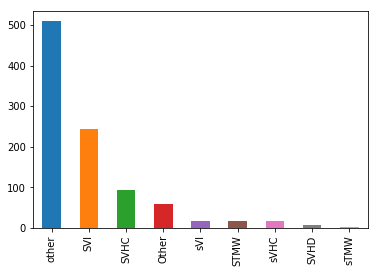

In [25]:
train['referral source'].value_counts().plot.bar();

In [26]:
train['referral source'].value_counts()

other    510
SVI      245
SVHC      94
Other     59
sVI       18
STMW      18
sVHC      17
SVHD       8
sTMW       3
Name: referral source, dtype: int64

The Data in this atribute is dis-organised so we can simply organise by combining like data to avoid case sensitivity

In [29]:
train.loc[(train['referral source']=='sVHC'), 'referral source'] = 'SVHC'
train.loc[(train['referral source']=='sVHD'), 'referral source'] = 'SVHD'
train.loc[(train['referral source']=='sVI'), 'referral source'] = 'SVI'
train.loc[(train['referral source']=='sTMW'), 'referral source'] = 'STMW'
train.loc[(train['referral source']=='Other'), 'referral source'] = 'other'


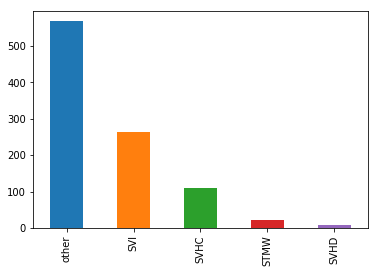

In [30]:
train['referral source'].value_counts().plot.bar();

In [32]:
train['referral source'].value_counts()

other    569
SVI      263
SVHC     111
STMW      21
SVHD       8
Name: referral source, dtype: int64

# query - hypop (OK)

# TSH, TSH measured (OK)
Obsahuje nevyplnené hodnoty, ktoré vyplníme mediánom. Outliery majú vysoké hodnoty ktoré je treba vyvážiť s ostatnými hodnotami. Kedže obsahuje hodnoty menšie ako 1, namiesto použitia logaritmu použijeme odmocninu.

### Stará distribúcia

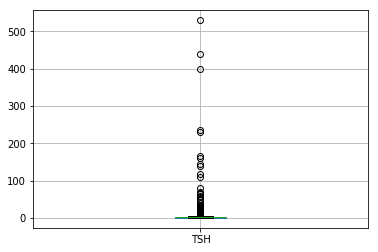

In [33]:
train.boxplot(column='TSH')         # filtrovany boxplot

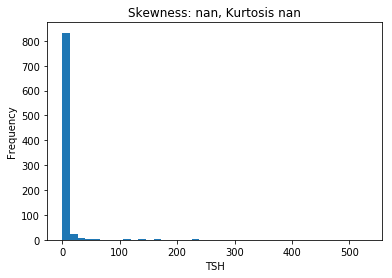

In [34]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['TSH']), (stats.kurtosis(train['TSH']))))
plt.xlabel('TSH')
train.TSH.plot(kind='hist', bins = 40)

### Transformácia distribúcie

In [100]:
print(train['TSH'].head())
train['TSH'].fillna(value=train['TSH'].median(), inplace=True)
train['TSH'] = train['TSH'].apply(lambda x: math.sqrt(x))
print(train['TSH'].head())

0    13.00
1      NaN
2     2.00
3     2.70
4     0.92
Name: TSH, dtype: float64
0    3.605551
1    1.183216
2    1.414214
3    1.643168
4    0.959166
Name: TSH, dtype: float64


### Nová distribúcia

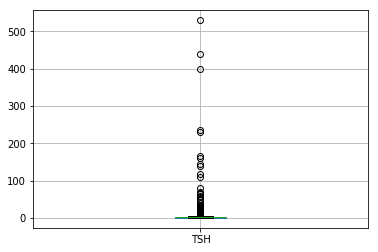

In [35]:
train.boxplot(column='TSH')

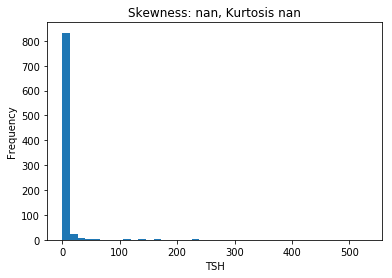

In [36]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['TSH']), (stats.kurtosis(train['TSH']))))
plt.xlabel('TSH')
train.TSH.plot(kind='hist', bins = 40)

# FTI
Pretypujeme typ object na float. Chýbajúce otáznikové hodnoty nahradíme mediánom.

In [37]:
train.loc[train['FTI'] == '?', 'FTI'] = -1
train['FTI'] = train['FTI'].astype(float) 
print('Pocet outlierov:', train[(train['FTI'] == -1)].count().iloc[0])
pom = train[(train['FTI'] > -1)]
print('Median:', pom['FTI'].median())
train.loc[train['FTI'] == -1, 'FTI'] = pom['FTI'].median()

Pocet outlierov: 90
Median: 106.0


### Distribúcia

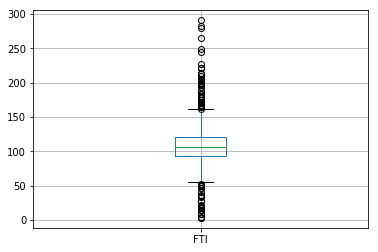

In [38]:
train.boxplot(column='FTI')

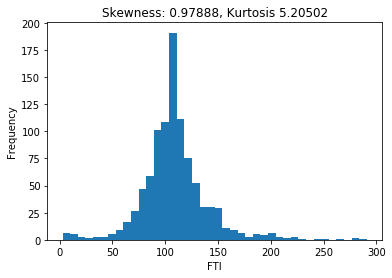

In [39]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['FTI']), (stats.kurtosis(train['FTI']))))
plt.xlabel('FTI')
train.FTI.plot(kind='hist', bins = 40)

# TBG

Pozostáva len z otáznikov, tento atribút môžeme zahodiť.

In [92]:
train.drop(columns=['TBG'], inplace=True)
train.drop(columns=['TBG measured'], inplace=True)

# fnlwgt
V nasledujúcich dvoch obrázkoch je vidiet veľká vychýlenosť hodnôt

### Stará distribúcia

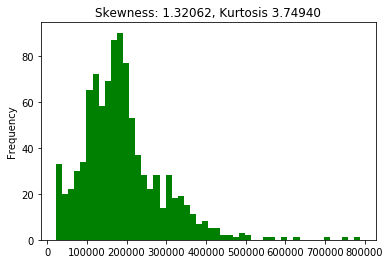

In [40]:
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['fnlwgt']), (stats.kurtosis(train['fnlwgt']))))
train.fnlwgt.plot(kind='hist', bins = 50, color="Green")

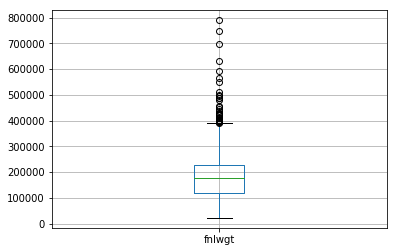

In [41]:
train.head()
train.boxplot(column='fnlwgt')

Outliery sú vo vysokách hodnotách. Na to, aby boli viac vyváženejšie s ostatnými, aplikujeme funkciu logaritmus.

### Nová distribúcia

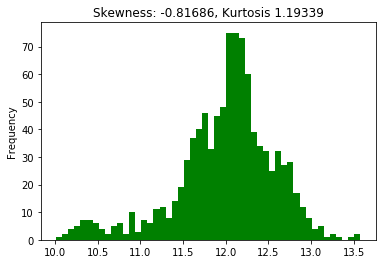

In [42]:
train['fnlwgt'] = train['fnlwgt'].apply(lambda x: math.log(x))    # aplikovanie funkcie logaritmus
plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['fnlwgt']), (stats.kurtosis(train['fnlwgt']))))
train.fnlwgt.plot(kind='hist', bins = 50, color="Green")

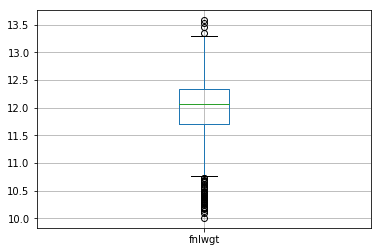

In [43]:
train.boxplot(column='fnlwgt')


# Psych
Problems : null and missing values

Changing data according to the relations found previously with other entities

In [111]:
train.loc[(train['psych']=='??' )  & (train['personal_info']== 'Wife'  ), 'psych'] = 'f'
train.loc[(train['psych']=='??' )  & (train['personal_info']== 'Husband'  ), 'psych'] = 'f'
train.loc[(train['psych']=='??' )  & (train['personal_info']== 'Own-child'  ), 'psych'] = 'f'

In [44]:
train['psych'].value_counts()

f     831
t      44
??     37
Name: psych, dtype: int64

In [48]:
train.loc[(train['psych']=='??' )  & (train['marital-status']== ' Married-spouse-absent'  ), 'psych'] = 'f'
train.loc[(train['psych']=='??' )  & (train['marital-status']== ' Widowed'  ), 'psych'] = 'f'
train.loc[(train['psych']=='??' )  & (train['marital-status']== ' Never-married'  ), 'psych'] = 'f'

In [49]:
train['psych'].value_counts()

f     848
t      44
??     20
Name: psych, dtype: int64

In [50]:
train.loc[(train['psych']=='??' )  & (train['personal_info']== 'Other-relative'  ), 'psych'] = 'f'
train.loc[(train['psych']=='??' )  & (train['personal_info']== 'Unmarried'  ), 'psych'] = 'f'
train.loc[(train['psych']=='??' )  & (train['personal_info']== 'Not-in-family'  ), 'psych'] = 'f'

In [51]:
train['psych'].value_counts()

f     857
t      44
??     11
Name: psych, dtype: int64

This column is resolved

filling the missing data with median of the enitity

In [52]:
train["psych"] = train["psych"].fillna(train["psych"].mode())
                                             
                                           

In [53]:
train['psych'].isnull().sum()


60

In [54]:
train.loc[(train['psych'].isnull())]

Unnamed: 0  age sex on thyroxine query on thyroxine  \
3             3   73   F            t                  f   
41           41   74   M            f                  f   
64           64   88   F            f                  f   
79           79   66   F            f                  f   
89           89   53   F            f                  f   
94           94   31   F            f                  f   
119         119   50   F            f                  f   
123         123   53   F            f                  f   
134         134   75   M            f                  f   
190         190   42   F            f                  f   
193         193   25   M            f                  f   
203         203   36   F            f                  f   
230         230   16   M            f                  f   
247         247   87   F            f                  f   
259         259   55   F            f                  f   
260         260   40   M            f                  f   
261         261   40   F            t                  f   
274         274   28   M            f                  f   
309         309   29   F            f                  f   
320         320   52   M            f                  f   
321         321   38   M            f                  f   
337         337   11   M            f                  f   
339         339   75   F            f                  f   
350         350   39   F            f                  f   
356         356   49   F            f                  f   
368         368   53   F            f                  f   
369         369   83   M            f                  f   
381         381   39   F            f                  f   
389         389   52   M            f                  f   
397         397   79   F            f                  f   
453         453   41   F            f                  f   
464         464   62   M            f                  f   
471         471   30   F            f                  f   
502         502   38   M            f                  f   
520         520   56   F            t                  f   
541         541   68   F            f                  f   
562         562   21   F            f                  f   
572         572   25   F            t                  f   
573         573   19   M            f                  f   
577         577   33   F            t                  f   
624         624   92   F            f                  f   
654         654   28   M            f                  f   
660         660   54   M            f                  f   
702         702   78   M            f                  f   
706         706   55   F            t                  f   
715         715   40   F            f                  f   
732         732   41   F            f                  f   
747         747   65   M            t                  f   
770         770   46   M            f                  f   
772         772   27   F            f                  f   
800         800   39   F            f                  f   
802         802   31   F            f                  f   
804         804   49   F            t                  f   
824         824   52   M            f                  f   
865         865   65   M            f                  f   
868         868   56   M            f                  f   
893         893   31   F            t                  f   
898         898   48   F            f                  f   
934         934   47   M            f                  f   
954         954   83   F            f                  f   

    on antithyroid medication sick pregnant thyroid surgery I131 treatment  \
3                           f    f        f               f              f   
41                          f    f        f               f              f   
64                          f    f        f               f              f   
79                          f   

filling the remaining data with mode of the row

# education-num
Obsahuje vychýlene hodnoty, ktoré stačí vydeliť číslom 100, v prípade záporného čísla číslom -100 a pretypovať typ float na integer.

### Nová distribúcia

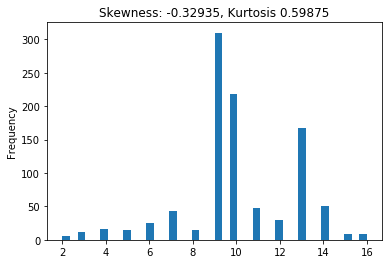

In [55]:
train.loc[train['education-num'] < 0, 'education-num'] /= -100
train.loc[train['education-num'] > 99, 'education-num'] /= 100
train['education-num'] = train['education-num'].astype(int) 

plt.title("Skewness: %.5f, Kurtosis %.5f" % (stats.skew(train['education-num']), (stats.kurtosis(train['education-num']))))
train['education-num'].plot(kind='hist', bins = 40)

# capital-gain
- nevyplnene hodnoty nahradime medianom (najcastejsou hodnotou 0)
- transformácia 12 outlierov taktiez medianom z intervalu hodnôt 10000 až 99998

In [56]:
print(train['capital-gain'].isnull().sum())
train["capital-gain"] = train["capital-gain"].fillna(train["capital-gain"].median())
train['capital-gain'].isnull().sum()

97


0

In [57]:
train["capital-gain"].head(30) 
train['psych'].head(30)

0       f
1       f
2       f
3     NaN
4       f
5       f
6       f
7       f
8       f
9       f
10      t
11      f
12      f
13     ??
14      f
15      f
16      f
17      f
18      f
19      f
20      f
21      f
22      f
23      f
24      f
25      f
26      f
27     ??
28      f
29      f
Name: psych, dtype: object

In [58]:
train['capital-gain'].describe()   # vacsina hodnot 0

count      972.000000
mean       940.258230
std       7449.547367
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [59]:
train.loc[train['education-num'] < 0, 'education-num'] /= -100
train.loc[train['education-num'] > 99, 'education-num'] /= 100
train['education-num'] = train['education-num'].astype(int) 


print('Pocet outlierov:', train[(train['capital-gain'] == 99999)].count().iloc[0])   # počet outlierov
pom = train[(train['capital-gain'] > 10000) & (train['capital-gain'] != 99999)]
print('Median:', pom['capital-gain'].median())                              # median
train.loc[train['capital-gain'] == 99999, 'capital-gain'] = pom['capital-gain'].median()

Pocet outlierov: 5
Median: 15024.0


# T3 T3 measured

problem: nan-values

Histograms to show us the distribution of the data with it's category inorder to find the best alternative for clearing or filling the data, which shows that mean can be the value which we can fill the missing values

# Before

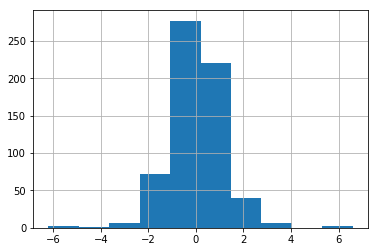

In [60]:
train["T3"].diff().hist()

In [61]:
train["T3"] = train["T3"].fillna(train["T3"].mean())
train["T3"].isnull().sum()

0

# After 

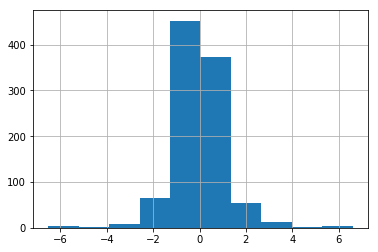

In [62]:
train["T3"].diff().hist()

# TT4 and T4


Problem: null vlaues

From the following histogram we can see that median can be suitable for filling in the missing rows

In [63]:
train["TT4"].isnull().sum()

47

# Before

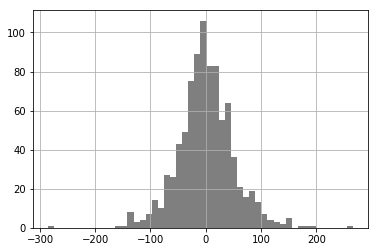

In [64]:
train["TT4"].diff().hist(color='k', alpha=0.5, bins=50)

# After

In [65]:
train["TT4"] = train["TT4"].fillna(train["TT4"].median())




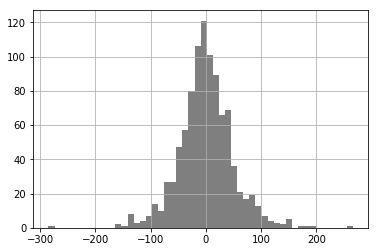

In [66]:
train["TT4"].diff().hist(color='k', alpha=0.5, bins=50)

In [67]:
train['TT4'].isnull().sum()

0



# T4U and T4U measured



Problems identified in the expoClass :  Missing values
Solution:  filling with median

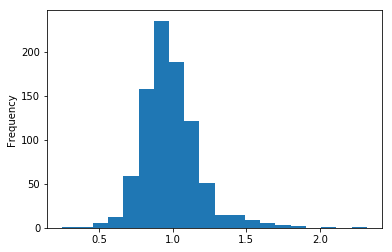

In [68]:
train["T4U"].plot.hist(stacked=True, bins=20)

In [69]:
train['T4U'].isnull().sum()

90

In [70]:
train["T4U"] = train["T4U"].fillna(train["T4U"].median())

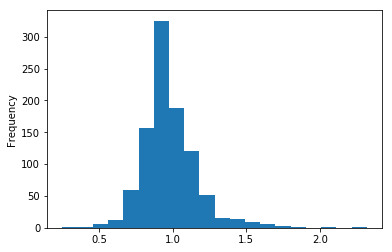

In [71]:
train["T4U"].plot.hist(stacked=True, bins=20)

# Workclass


Problems: wronng values
Solution: filling with the most used values in the entity

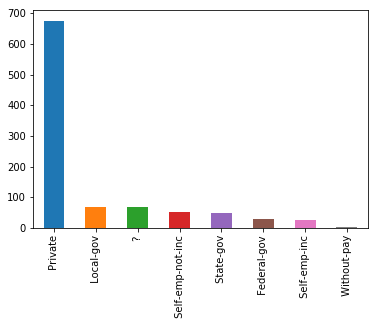

In [72]:
train['workclass'].value_counts().plot.bar();

In [73]:
train.loc[(train['workclass']==' ?' ) , 'workclass'] =  train["workclass"].mode()

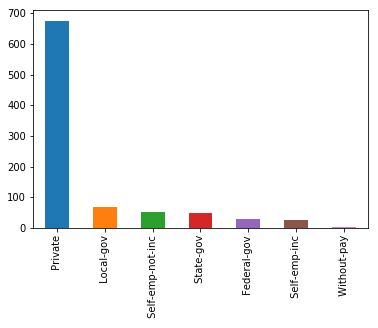

In [74]:
train['workclass'].value_counts().plot.bar();



# Occupation class

Problems: Disorganised and wrong values
Solution: filling with mode and relations found in the expoClass

In [75]:
train.loc[(train['occupation']== ' ?'), 'occupation'] = train["occupation"].mode()
train.loc[(train['occupation']== ' Priv-house-serv'), 'occupation'] = 'Priv-house-serv'
train.loc[(train['occupation']== ' ?' ) & (train['class']== 'sick'),  'occupation'] = 'Priv-house-serv'


In [76]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

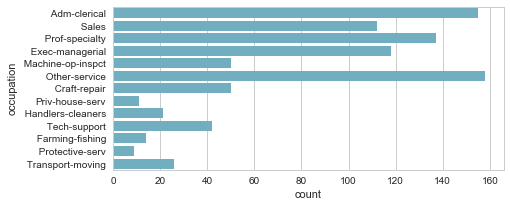

In [77]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="occupation", data=train, color="c");

Country

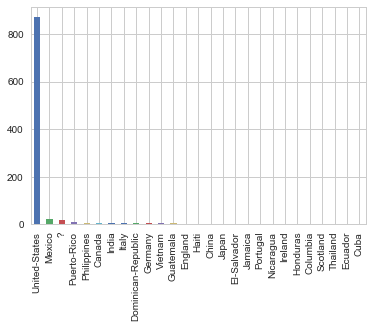

In [78]:
train['Country'].value_counts().plot.bar();

In [79]:
train.loc[(train['Country']== '?'), 'Country'] = train["Country"].mode()

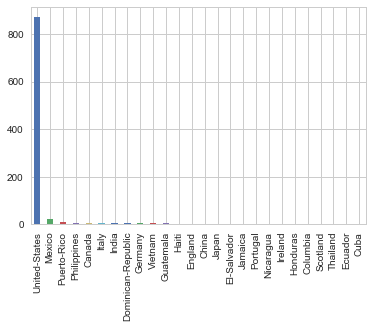

In [80]:
train['Country'].value_counts().plot.bar();

# Capital-loss (OK)

# hours per week
Neobsahuje chýbajúce hodnoty, má však vychýlené hodnoty 99 ktoré by sa mohli nahradiť najfrekventovanejšou hodnotou 40. (modusom).

In [81]:
train['hours-per-week'].describe()

count    972.000000
mean      38.330247
std       12.152354
min        2.000000
25%       35.000000
50%       40.000000
75%       40.000000
max       99.000000
Name: hours-per-week, dtype: float64

In [82]:
train.loc[train['hours-per-week'] == 99, 'hours-per-week'] = train["hours-per-week"].mode()
train['hours-per-week'].describe()

count    970.000000
mean      38.205155
std       11.847856
min        2.000000
25%       35.000000
50%       40.000000
75%       40.000000
max       84.000000
Name: hours-per-week, dtype: float64

Feature Standardisation
Label Encoding


In [84]:
train.to_csv('repairedTest.csv')